<b><center><font size="20">Machine learning projection of climate and technology impacts on crops key to food security</font></center></b>

<center><font size="10">  </font></center>

In [39]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Front matter

In [2]:
%matplotlib inline
# %matplotlib

In [3]:
# Loading libaries
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.optimize import curve_fit
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
from statsmodels.formula.api import ols
from matplotlib.lines import Line2D
from linearmodels.panel import PanelOLS




In [4]:
cwd = os.getcwd()
data_dir = cwd+'/inputs/'

## Training

In [5]:
def fit_ar_model(exog_train, endog_train):
    # Fit an Ordinary Least Squares (OLS) model to the training data
    model_ols = sm.OLS(endog_train, exog_train)
    results = model_ols.fit()
    
    # Calculate residuals and predictions
    residuals = results.resid
    y_pred = results.predict(exog_train)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = sqrt(mean_squared_error(endog_train, y_pred))
    return results, residuals, rmse

def model_func(X, a, k, b1, b2, l1, l2):
    t, T, T2, Y_lag1, Y_lag2 = X
    return (a * np.exp(-k * t)) + b1 * T + b2 * T2 + l1 * Y_lag1 + l2 * Y_lag2
    # a * exp(-k * t): exponentially decaying component
    # b1 * T + b2 * T2: linear components with respect to T and T^2
    # l1 * Y_lag1 + l2 * Y_lag2: autoregressive components based on past values

def fit_ar_tvexpa0_model(X, Y, initial_guess):
    # Fit a nonlinear curve using the model_func and the provided initial parameters
    popt, pcov = curve_fit(model_func, (X['Time'], X['T'], X['T2'], X['yield_lag1'], X['yield_lag2']), Y, p0=initial_guess)
    # popt: optimal values for the parameters that best fit the data
    # pcov: covariance of popt estimates
    
    # Generate predictions using the optimized parameters
    Y_pred = model_func((X['Time'], X['T'], X['T2'], X['yield_lag1'], X['yield_lag2']), *popt)
    
    residuals = Y - Y_pred
    rmse = sqrt(mean_squared_error(Y, Y_pred))
    return {'popt': popt, 'pcov': pcov}, residuals, rmse

def process_data_for_model_training(data, samplesize, time_diff=3, model_type='AR'):
    constant = [1] * samplesize
    exog = pd.DataFrame({'constant': constant})
    exog['T'] = data['x1'].values
    exog['T2'] = data['x2'].values
    exog['yield_lag1'] = data['yield_LogR_lag1'].values
    exog['yield_lag2'] = data['yield_LogR_lag2'].values
    
    # For certain models, adjust the Time variable
    if model_type not in ['AR', 'AR_recent']:
        exog['Time'] = data['Time'].values - time_diff
        
    endog = data['yield_LogR'].values
    
    
    return exog, endog # Return the exogenous and endogenous variables



In [6]:
def model_training(Model, train_sample):
    # Initialize results storage
    all_fitting_results = {f'data_InSample_{Model}': [],
                           f'model_result_{Model}': [], 
                           f'residuals_{Model}_all': [], 
                           f'rmse_{Model}_all': []}

    # Process the data to prepare it for model fitting
    data_slice = train_sample
    exog_train, endog_train = process_data_for_model_training(data_slice, len(train_sample), model_type=Model)
    
    # Store the entire dataset used for training
    all_fitting_results[f'data_InSample_{Model}'].append(exog_train.copy())
    
    # Store the in-sample data used for training
    if Model in ['AR', 'AR_recent', 'AR_TVLa0']:  # 'AR': MAR-X model with constant intercept; 'AR_recent': MAR-X model with constant intercept + latest 25 years data; 'AR_TVLa0': MAR-X model with linearly decay intercept
        results, residuals, rmse = fit_ar_model(exog_train, endog_train)
    elif Model == 'AR_TVEa0':  # MAR-X model exponentially decay intercept
        results, residuals, rmse = fit_ar_tvexpa0_model(exog_train, endog_train, [0.04, 0.03, 0, 0, 0, 0])
    else:
        raise ValueError(f"Unknown model type: {Model}")
    
    # Store model fitting results
    all_fitting_results[f'model_result_{Model}'].append(results)
    all_fitting_results[f'residuals_{Model}_all'].append(residuals)
    all_fitting_results[f'rmse_{Model}_all'].append(rmse)
    
    return all_fitting_results


## Projection

In [7]:
def calculate_yield_logR(model_version, df_pr_project_fv, idx_range, a0, b1, b2, r1, r2, ii=None):
    """
    Calculate the yield log returns for various model specifications.
    
    Args:
        model_version (str): The version of the model being used ('const', 'const_recent', 'lin', 'exp').
        df_pr_project_fv (pd.DataFrame): DataFrame with the climate model projections.
        idx_range (range): The index range for the current iteration.
        a0 (float or array): The intercept term(s) for the model.
        b1 (float): The coefficient for the 'T' variable.
        b2 (float): The coefficient for the 'T2' variable.
        r1 (float): The coefficient for the 'yield_LogR_lag1' variable.
        r2 (float): The coefficient for the 'yield_LogR_lag2' variable.
        ii (int, optional): Index for linear or exponential models, required if a0 is an array.
    
    Returns:
        tuple: Two arrays representing `yield_logR_update` and `yield_logR_NoCC`.
    """
    if model_version in ['lin', 'exp']:
        a0_value = a0[ii]
    else:
        a0_value = a0

    yield_logR_update = (
        a0_value + b1 * df_pr_project_fv.loc[idx_range, 'T'].values
        + b2 * df_pr_project_fv.loc[idx_range, 'T2'].values
        + r1 * df_pr_project_fv.loc[idx_range, 'yield_LogR_lag1'].values
        + r2 * df_pr_project_fv.loc[idx_range, 'yield_LogR_lag2'].values
    )

    yield_logR_NoCC = (
        a0_value + r1 * df_pr_project_fv.loc[idx_range, 'yield_LogR_lag1_NoCC'].values
        + r2 * df_pr_project_fv.loc[idx_range, 'yield_LogR_lag2_NoCC'].values
    )

    return yield_logR_update, yield_logR_NoCC


In [8]:
def projection_process(model_version, rcp_number, climate_models, country_size, cwd, crop_name):
    """
    Process the model version and update the production projection values accordingly.

    Args:
        model_version (str): The version of various intercept functions and sample size ('const', 'const_recent', 'lin', 'exp').
        rcp_number (int): The RCP number being processed.
        climate_models (list): List of climate models to process.
        country_size (int): The size of the country (number of records per time period).
        cwd (str): Current working directory.
        crop_name (str): Crop type.

    Returns:
        pd.DataFrame: A DataFrame with the global production sums for the given model version.
    """
    # Initialize the DataFrame to store production sums
    df_production_sum = pd.DataFrame()

    df_production_base_org = pd.read_csv(cwd+'/inputs/projection/' + f'{crop_name}_production_2018_NoOutlier.csv')
    
    with open(data_dir + f'train_sample_{crop_name}_full.pkl','rb') as f:
        train_sample_full = pickle.load(f)

    with open(data_dir + f'train_sample_{crop_name}_latest25yr.pkl','rb') as f:
        train_sample_latest25yr = pickle.load(f)
        
    model_training_results_AR = model_training('AR', train_sample_full)
    model_training_results_AR_25yr = model_training('AR_recent', train_sample_latest25yr)
    model_training_results_AR_TVLa0= model_training('AR_TVLa0', train_sample_full)
    model_training_results_AR_TVEa0 = model_training('AR_TVEa0', train_sample_full)
    
    a0_const = (model_training_results_AR['model_result_AR'][0]).params['constant']
    b1_const = (model_training_results_AR ['model_result_AR'][0]).params['T']
    b2_const = (model_training_results_AR ['model_result_AR'][0]).params['T2']
    r1_const = (model_training_results_AR['model_result_AR'][0]).params['yield_lag1']
    r2_const = (model_training_results_AR['model_result_AR'][0]).params['yield_lag2']

    a0_const_recent = (model_training_results_AR_25yr['model_result_AR_recent'][0]).params['constant']
    b1_const_recent = (model_training_results_AR_25yr ['model_result_AR_recent'][0]).params['T']
    b2_const_recent = (model_training_results_AR_25yr ['model_result_AR_recent'][0]).params['T2']
    r1_const_recent = (model_training_results_AR_25yr['model_result_AR_recent'][0]).params['yield_lag1']
    r2_const_recent = (model_training_results_AR_25yr['model_result_AR_recent'][0]).params['yield_lag2']

    a_exp = (model_training_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[0]
    k_exp = (model_training_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[1]
    b1_exp = (model_training_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[2]
    b2_exp = (model_training_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[3]
    r1_exp = (model_training_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[4]
    r2_exp = (model_training_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[5]

    c_lin = (model_training_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['constant']
    r_lin = (model_training_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['Time']
    b1_lin = (model_training_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['T']
    b2_lin = (model_training_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['T2']
    r1_lin = (model_training_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['yield_lag1']
    r2_lin = (model_training_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['yield_lag2']

    time_data = np.array(range(1,55))  # In-sample has 54 years
    annual_time_data = np.arange(time_data.max()+1, time_data.max() + 80 + 1) # project for the 80 years in the future
    def exp_decay(t, a, k):
        return a * np.exp(-k * t)
    a0_exp = exp_decay(annual_time_data, round(a_exp,4), round(k_exp,4))

    def linear_decay(t, C, r):
        return C + r * t
    a0_lin = linear_decay(annual_time_data, round(c_lin,4), round(r_lin,4))
    a0_lin[a0_lin < 0] = 0
    
    for model_index in climate_models:
        df_pr_project_fv = pd.read_csv(cwd+'/inputs/projection/' + f'df_{crop_name}_project_RCP{rcp_number}_model_{model_index}.csv')
        df_pr_project_fv.reset_index(drop=True, inplace=True)

        df_pr_project_fv['yield_LogR_lag1_NoCC'] = df_pr_project_fv['yield_LogR_lag1']
        df_pr_project_fv['yield_LogR_lag2_NoCC'] = df_pr_project_fv['yield_LogR_lag2']

        yield_raw_input_initial = pd.read_csv(cwd+'/inputs/projection/' + f'df_{crop_name}_project_RCP{rcp_number}_model_{model_index}_yield_raw_input_initial.csv')

        for ii in range(int(len(df_pr_project_fv) / country_size)):
            idx_range = range(country_size * ii, country_size * (ii + 1))

            if model_version == 'const':
                yield_logR_update, yield_logR_NoCC = calculate_yield_logR(
                    model_version, df_pr_project_fv, idx_range, a0_const, b1_const, b2_const, r1_const, r2_const
                )
            elif model_version == 'const_recent':
                yield_logR_update, yield_logR_NoCC = calculate_yield_logR(
                    model_version, df_pr_project_fv, idx_range, a0_const_recent, b1_const_recent, b2_const_recent, r1_const_recent, r2_const_recent
                )
            elif model_version == 'lin':
                yield_logR_update, yield_logR_NoCC = calculate_yield_logR(
                    model_version, df_pr_project_fv, idx_range, a0_lin, b1_lin, b2_lin, r1_lin, r2_lin, ii
                )
            elif model_version == 'exp':
                yield_logR_update, yield_logR_NoCC = calculate_yield_logR(
                    model_version, df_pr_project_fv, idx_range, a0_exp, b1_exp, b2_exp, r1_exp, r2_exp, ii
                )

            yield_logR_extra = yield_logR_update - yield_logR_NoCC

            # Update yield and production values
            if ii == 0:
                yield_raw_base = yield_raw_input_initial['yield_raw'].values
                production_base = df_production_base_org['Production_Y2018'].values
            else:
                yield_raw_base = df_pr_project_fv.loc[country_size * (ii-1):country_size * ii - 1, 'yield_raw'].values
                production_base = df_pr_project_fv.loc[country_size * (ii-1):country_size * ii - 1, 'production_raw'].values

            yield_raw_update = yield_raw_base * np.exp(yield_logR_update)
            yield_raw_NoCC_update = yield_raw_base * np.exp(yield_logR_NoCC)
            production_raw_update = production_base * np.exp(yield_logR_update)
            production_raw_NoCC_update = production_base * np.exp(yield_logR_NoCC)

            # Store results back in the DataFrame
            df_pr_project_fv.loc[idx_range, f'yield_raw'] = yield_raw_update
            df_pr_project_fv.loc[idx_range, f'yield_raw_NoCC'] = yield_raw_NoCC_update
            df_pr_project_fv.loc[idx_range, f'production_raw'] = production_raw_update
            df_pr_project_fv.loc[idx_range, f'production_raw_NoCC'] = production_raw_NoCC_update

            df_pr_project_fv.loc[idx_range, f'yield_LogR'] = yield_logR_update
            df_pr_project_fv.loc[idx_range, f'yield_LogR_NoCC'] = yield_logR_NoCC
            df_pr_project_fv.loc[idx_range, f'yield_LogR_extra'] = yield_logR_extra

            # Update lagged values for the next iteration
            if ii < int(len(df_pr_project_fv) / country_size) - 1:
                next_idx_range = range(country_size * (ii + 1), country_size * (ii + 2))
                df_pr_project_fv.loc[next_idx_range, f'yield_LogR_lag1'] = yield_logR_update
                df_pr_project_fv.loc[next_idx_range, f'yield_LogR_lag2'] = df_pr_project_fv.loc[idx_range, f'yield_LogR_lag1'].values
                df_pr_project_fv.loc[next_idx_range, f'yield_LogR_lag1_NoCC'] = yield_logR_NoCC
                df_pr_project_fv.loc[next_idx_range, f'yield_LogR_lag2_NoCC'] = df_pr_project_fv.loc[idx_range, f'yield_LogR_lag1_NoCC'].values

        # Summing up production values
        df_production_sum[f'sum_production_Model_{model_index}'] = df_pr_project_fv.groupby('Year')[f'production_raw'].sum().values
        df_production_sum[f'sum_production_NoCC_Model_{model_index}'] = df_pr_project_fv.groupby('Year')[f'production_raw_NoCC'].sum().values

    df_production_sum['Year'] = df_pr_project_fv['Year'].unique() 
    # Reorder the DataFrame columns to place 'Year' as the first column
    cols = df_production_sum.columns.tolist()
    cols = ['Year'] + [col for col in cols if col != 'Year']
    df_production_sum = df_production_sum[cols]

    return df_production_sum


In [16]:
#Required information for projection (example of wheat data):
countries_all = {}
countries_all['wheat'] = ['Peru', 'Tanzania', 'Albania', 'Algeria', 'Bangladesh', 'Bolivia', 'Bulgaria', 'Denmark', 
                 'Egypt', 'France', 'Germany', 'Hungary', 'India', 'Iran', 'Iraq', 'Israel', 'Japan', 'Lebanon', 
                 'Libya', 'Mexico', 'Morocco', 'Myanmar', 'Nepal', 'Pakistan', 'Poland', 'Romania', 'Saudi Arabia', 
                 'South Korea', 'Spain', 'Sweden', 'Syria', 'Tunisia', 'United Kingdom', 'Canada', 'China', 'Italy', 
                 'North Korea', 'Turkey', 'United States','Russia', 'Ukraine', 'Zimbabwe', 'Australia', 'Colombia', 'Ecuador', 'Guatemala', 
                 'Kenya', 'Angola', 'Argentina', 'Brazil', 'Chile', 'Lesotho', 'Mozambique', 'Namibia', 
                 'Paraguay', 'South Africa', 'Uruguay']

with open(cwd+'/inputs/projection/' + 'common_models.pkl', 'rb') as file:
    climate_models = pickle.load(file)


# MAR-X Training, Validation & Projection Demonstration for wheat data (Figure 1)

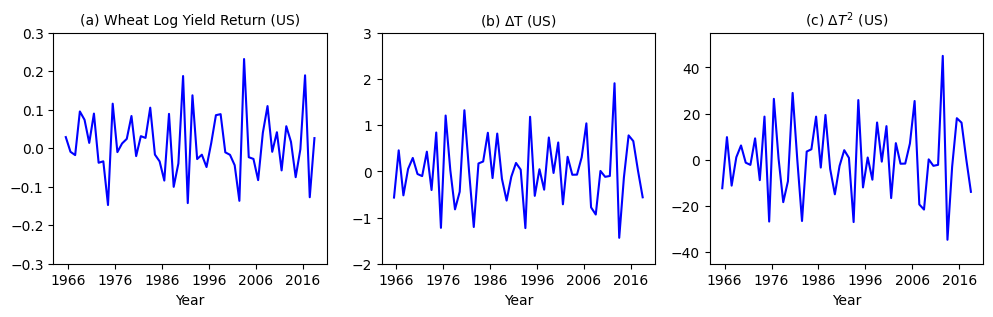

In [17]:
#Historical data
with open(data_dir+'train_sample_wheat.pkl', 'rb') as f: #open dataframe of historical data for wheat
    train_sample = pickle.load(f)

# Preparing input data 
filtered_df_LogR = train_sample.copy()
country_eg = 'United States'
filtered_df = filtered_df_LogR[filtered_df_LogR['Country'] == country_eg]
unique_years = sorted(filtered_df['Year'])
x_values = unique_years 
y_values = [filtered_df[filtered_df['Year'] == year]['yield_LogR'] for year in unique_years]

xT_values = unique_years
yT_values = [filtered_df[filtered_df['Year'] == year]['x1'] for year in unique_years]

xT2_values = unique_years
yT2_values = [filtered_df[filtered_df['Year'] == year]['x2'] for year in unique_years]

#plot - subplots (a) (b) (c) in Figure 1
plt.figure(figsize=(12, 3))
ax1 = plt.subplot(1,3,1)
ax1.plot(x_values, y_values, linestyle='-', label='Log Yield Return', color='blue')
tick_positions = [i + 0.5 for i in range(unique_years[0], unique_years[-1], 10)]
tick_labels = (np.array(filtered_df['Year'].unique()) + 2)[::10]
ax1.set_xticks(tick_positions, tick_labels)
ax1.set_title('(a) Wheat Log Yield Return (US)', fontsize=10)
ax1.set_xlabel('Year', fontsize=10)
ax1.set_ylim(-0.3, 0.3)

ax2 = plt.subplot(1,3,2)
ax2.plot(xT_values, yT_values, linestyle='-', label='$\Delta$T', color='blue')
ax2.set_xticks(tick_positions, tick_labels)
ax2.set_title('(b) $\Delta$T (US)', fontsize=10)
ax2.set_xlabel('Year', fontsize=10)
ax2.set_ylim(-2, 3)

ax3 = plt.subplot(1,3,3)
ax3.plot(xT2_values, yT2_values, linestyle='-', label='ΔT2', color='blue')
ax3.set_xticks(tick_positions, tick_labels)
ax3.set_title('(c) $\Delta$$T^2$ (US)', fontsize=10)
ax3.set_xlabel('Year', fontsize=10)
ax3.set_ylim(-45, 55)

plt.show()


In [10]:
# Crop production level data span from 1962 to 2018 (57 years). However, the initial year of our dataset is 1961. For 1961, only climate data are used, not crop production data, as multi-season crops may require climate data from 1960.
# Given that our response variable is the log return of crop yield, the sample size is 56 for each country.
# Since two lagged values are used as covariates (1963-1962; 1964-1963), the sample size of the response variable for each country is reduced to 54.


In [18]:
#Training models

#Load sample data (1961 - 1996)
with open(data_dir + 'train_sample_wheat_example.pkl','rb') as f:
    train_sample_wheat_example = pickle.load(f)
    
wheat_fitting_results_AR = model_training('AR', train_sample_wheat_example)
wheat_fitting_results_AR_TVLa0 = model_training('AR_TVLa0', train_sample_wheat_example)
wheat_fitting_results_AR_TVEa0 = model_training('AR_TVEa0', train_sample_wheat_example)

In [19]:
#Estimated coefficients in the models
a0_const = (wheat_fitting_results_AR['model_result_AR'][0]).params['constant']
b1_const = (wheat_fitting_results_AR ['model_result_AR'][0]).params['T']
b2_const = (wheat_fitting_results_AR ['model_result_AR'][0]).params['T2']
r1_const = (wheat_fitting_results_AR['model_result_AR'][0]).params['yield_lag1']
r2_const = (wheat_fitting_results_AR['model_result_AR'][0]).params['yield_lag2']

c_lin = (wheat_fitting_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['constant']
r_lin = (wheat_fitting_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['Time']
b1_lin = (wheat_fitting_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['T']
b2_lin = (wheat_fitting_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['T2']
r1_lin = (wheat_fitting_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['yield_lag1']
r2_lin = (wheat_fitting_results_AR_TVLa0 ['model_result_AR_TVLa0'][0]).params['yield_lag2']

a_exp = (wheat_fitting_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[0]
k_exp = (wheat_fitting_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[1]
b1_exp = (wheat_fitting_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[2]
b2_exp = (wheat_fitting_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[3]
r1_exp = (wheat_fitting_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[4]
r2_exp = (wheat_fitting_results_AR_TVEa0 ['model_result_AR_TVEa0'][0]['popt'])[5]


with open(data_dir + 'Forecast_multi_step_ahead_wheat.pkl','rb') as f:
    Forecast_multi_step_ahead = pickle.load(f)
    
country_num=55
yield_lagR_all = []
yield_lagR_TVLa0_all = []
a0_lin = []
yield_lagR_TVEa0_all = []
production_1962_base = pd.read_csv(data_dir + 'Wheat_production_1962_2018_NoOutlier.csv')
forecast_len = len(Forecast_multi_step_ahead) // country_num
#Generate multi-step-ahead forecasts:
for ii in range(forecast_len):
    start_idx = country_num * ii
    end_idx = country_num * (ii + 1)
    current_slice = Forecast_multi_step_ahead.iloc[start_idx:end_idx]

    # Calculate yield_lagR_temp
    yield_lagR_temp = (a0_const +
                       b1_const * current_slice['x1'].values +
                       b2_const * current_slice['x2'].values +
                       r1_const * current_slice['yield_LogR_lag1_AR'].values +
                       r2_const * current_slice['yield_LogR_lag2_AR'].values)
    yield_lagR_all.append(yield_lagR_temp)

    # Calculate yield_lagR_temp_TVL
    next_a0_lin = c_lin + r_lin * (ii + 33) # the intercept value under the assumption of linearly decay function
    a0_lin.append(max(0, next_a0_lin))
    yield_lagR_temp_TVL = (a0_lin[ii] +
                           b1_lin * current_slice['x1'].values +
                           b2_lin * current_slice['x2'].values +
                           r1_lin * current_slice['yield_LogR_lag1_TVLa0'].values +
                           r2_lin * current_slice['yield_LogR_lag2_TVLa0'].values)
    yield_lagR_TVLa0_all.append(yield_lagR_temp_TVL)

    # Calculate yield_lagR_temp_TVE
    yield_lagR_temp_TVE = model_func(((ii + 33),
                                      current_slice['x1'].values,
                                      current_slice['x2'].values,
                                      current_slice['yield_LogR_lag1_TVEa0'].values,
                                      current_slice['yield_LogR_lag2_TVEa0'].values),
                                     a_exp, k_exp, b1_exp, b2_exp, r1_exp, r2_exp)
    yield_lagR_TVEa0_all.append(yield_lagR_temp_TVE)

    # Update production_raw_update and related fields
    if ii == 0:
        production_raw_update = production_1962_base[f'Y{1996}'].values * np.exp(yield_lagR_temp)
        production_raw_update_TVL = production_1962_base[f'Y{1996}'].values * np.exp(yield_lagR_temp_TVL)
        production_raw_update_TVE = production_1962_base[f'Y{1996}'].values * np.exp(yield_lagR_temp_TVE)
    else:
        prev_slice = Forecast_multi_step_ahead.iloc[start_idx - country_num:end_idx - country_num]
        production_raw_update = prev_slice['production_raw_iterative'].values * np.exp(yield_lagR_temp)
        production_raw_update_TVL = prev_slice['production_raw_iterative_TVLa0'].values * np.exp(yield_lagR_temp_TVL)
        production_raw_update_TVE = prev_slice['production_raw_iterative_TVEa0'].values * np.exp(yield_lagR_temp_TVE)

    # Assign updates to the dataframe
    Forecast_multi_step_ahead.loc[range(start_idx,end_idx), 'production_raw_iterative'] = production_raw_update
    Forecast_multi_step_ahead.loc[range(start_idx,end_idx), 'production_raw_iterative_TVLa0'] = production_raw_update_TVL
    Forecast_multi_step_ahead.loc[range(start_idx,end_idx), 'production_raw_iterative_TVEa0'] = production_raw_update_TVE

    # Update lagged fields for next iteration
    if ii < forecast_len - 1:
        next_start_idx = end_idx
        next_end_idx = end_idx + country_num
        Forecast_multi_step_ahead.loc[range(next_start_idx,next_end_idx), 'yield_LogR_lag1_AR'] = yield_lagR_all[ii]
        Forecast_multi_step_ahead.loc[range(next_start_idx,next_end_idx), 'yield_LogR_lag2_AR'] = current_slice['yield_LogR_lag1_AR'].values
        Forecast_multi_step_ahead.loc[range(next_start_idx,next_end_idx), 'yield_LogR_lag1_TVLa0'] = yield_lagR_TVLa0_all[ii]
        Forecast_multi_step_ahead.loc[range(next_start_idx,next_end_idx), 'yield_LogR_lag2_TVLa0'] = current_slice['yield_LogR_lag1_TVLa0'].values
        Forecast_multi_step_ahead.loc[range(next_start_idx,next_end_idx), 'yield_LogR_lag1_TVEa0'] = yield_lagR_TVEa0_all[ii]
        Forecast_multi_step_ahead.loc[range(next_start_idx,next_end_idx), 'yield_LogR_lag2_TVEa0'] = current_slice['yield_LogR_lag1_TVEa0'].values




In [20]:
#Generate several series of intercepts

a0_const_all = []
a0_lin_all = []
a0_exp_all = []

for ii in range(forecast_len+80): #80 refers to a projection period of 80 years into the future
    
    a0_const_all.append(a0_const)
    
    next_a0_lin = c_lin + r_lin * (ii + 33)
    if len(a0_lin_all) > 0 and a0_lin_all[-1] == 0:
        a0_lin_all.append(0)
    else:
        a0_lin_all.append(max(0, next_a0_lin))
    
    a0_exp_all.append(a_exp * np.exp(-k_exp * (ii + 33)))


In [21]:
global_multi_sum_const = Forecast_multi_step_ahead.groupby('Year', observed=True)['production_raw_iterative'].sum()
global_multi_sum_lin = Forecast_multi_step_ahead.groupby('Year', observed=True)['production_raw_iterative_TVLa0'].sum()
global_multi_sum_exp = Forecast_multi_step_ahead.groupby('Year', observed=True)['production_raw_iterative_TVEa0'].sum()
global_multi_sum_true = Forecast_multi_step_ahead.groupby('Year', observed=True)['production_raw'].sum()
global_multi_sum_true_previous = Forecast_multi_step_ahead.groupby('Year', observed=True)['production_raw_previous'].sum()

change_percent_real = (np.array(global_multi_sum_true) - np.array(global_multi_sum_true_previous)[0])/(np.array(global_multi_sum_true_previous)[0])*100
change_percent_const = (np.array(global_multi_sum_const) - np.array(global_multi_sum_true_previous)[0])/(np.array(global_multi_sum_true_previous)[0])*100
change_percent_lin = (np.array(global_multi_sum_lin) - np.array(global_multi_sum_true_previous)[0])/(np.array(global_multi_sum_true_previous)[0])*100
change_percent_exp = (np.array(global_multi_sum_exp) - np.array(global_multi_sum_true_previous)[0])/(np.array(global_multi_sum_true_previous)[0])*100



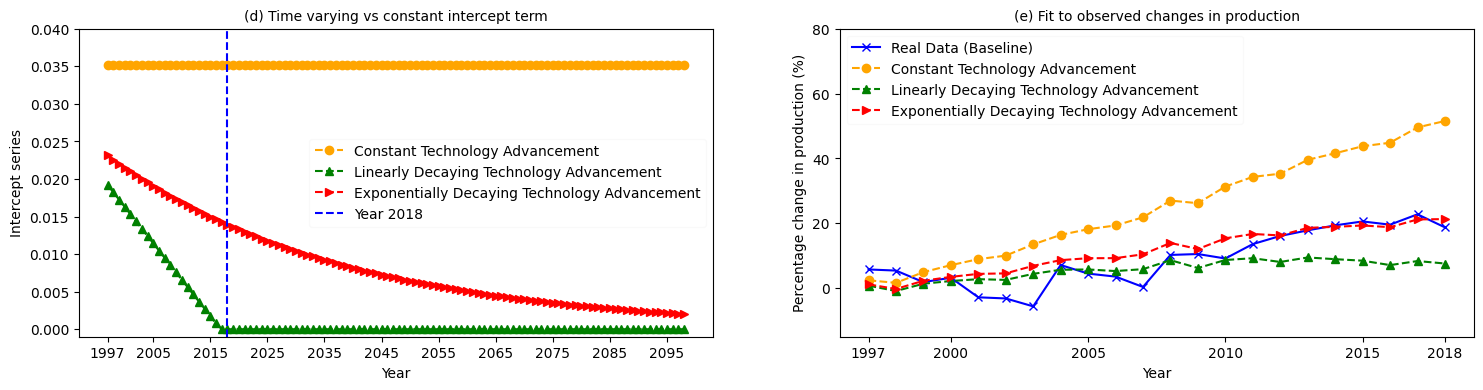

In [22]:
#plot - subplots (d) and (e) in Figure 1
plt.figure(figsize=(18, 4))
years = np.arange(1997, 1997 + len(a0_const_all))

ax1 = plt.subplot(1,2,1)
ax1.plot(years, a0_const_all, label='Constant Technology Advancement', marker='o', linestyle='--', color='orange')
ax1.plot(years, a0_lin_all, label='Linearly Decaying Technology Advancement', marker='^', linestyle='--', color='green')
ax1.plot(years, a0_exp_all, label='Exponentially Decaying Technology Advancement', marker='>', linestyle='--', color='red')
ax1.axvline(x=2018, color='blue', linestyle='--', label='Year 2018')
ax1.set_xlabel('Year', fontsize=10)
ax1.set_ylabel('Intercept series', fontsize=10)
ax1.set_title('(d) Time varying vs constant intercept term', fontsize=10)
ax1.legend(framealpha=0.1, fontsize=10)  # Semi-transparent legend box
custom_ticks = [1997, 2005, 2015, 2025, 2035, 2045, 2055, 2065, 2075, 2085, 2095]
ax1.set_xticks(custom_ticks)
ax1.set_ylim(-0.001,0.04)

ax2 = plt.subplot(1,2,2)
ax2.plot((global_multi_sum_const.index.astype(int)), change_percent_real, label='Real Data (Baseline)', marker='x',color='blue')
ax2.plot((global_multi_sum_const.index.astype(int)), change_percent_const, label=f'Constant Technology Advancement', marker='o',linestyle='--',color='orange')
ax2.plot((global_multi_sum_const.index.astype(int)), change_percent_lin, label=f'Linearly Decaying Technology Advancement', marker='^',linestyle='--',color='green')
ax2.plot((global_multi_sum_const.index.astype(int)), change_percent_exp, label=f'Exponentially Decaying Technology Advancement', marker='>',linestyle='--',color='red')
ax2.set_xlabel('Year', fontsize=10)
ax2.set_ylabel('Percentage change in production (%)', fontsize=10)
ax2.set_title('(e) Fit to observed changes in production', fontsize=10)
ax2.legend(framealpha=0.1, fontsize=10)  # Semi-transparent legend box
custom_ticks = [1997, 2000, 2005, 2010, 2015, (global_multi_sum_const.index.astype(int))[-1]]
ax2.set_xticks(custom_ticks)
ax2.set_ylim(-15,80)

plt.show()


In [23]:
# This will take approximately 2.5 minutes

rcp_numbers = [26, 45, 85]
crop_names = ['wheat']
dataframes_production_crops={}
# Now call the function 'projection_process' for each model version and store the results.
for crop_name in crop_names:
    country_size = len(countries_all[crop_name])
    dataframes_production_rcp = {}
    for rcp_number in rcp_numbers:
        dataframes_production = {}
        for model_version in ['const', 'const_recent', 'lin', 'exp']:
            df_production_sum = projection_process(model_version, rcp_number, climate_models, country_size, cwd,crop_name)
            intercept_key_name = f'intercept_{model_version}'
            dataframes_production[intercept_key_name] = df_production_sum.copy()
        rcp_key_name = f'RCP{rcp_number}'
        dataframes_production_rcp[rcp_key_name] = dataframes_production.copy()

    crop_key_name = f'{crop_name}'
    dataframes_production_crops[crop_key_name] = dataframes_production_rcp

In [24]:
#Calculate the percentage change in projected production relative to the base year of 2018

difference_results = {}
average_results = {}
quantile_25_results = {}
quantile_75_results = {}
combined_data_production_percent_change = {}

# File suffixes for different scenarios
rcp_suffixes = ["85", "45", "26"]
crop_suffixes = ["wheat"]
intercept_model_suffixes = ['const', 'const_recent', 'lin', 'exp']

for crop in crop_suffixes:
    production_initial_total = pd.read_csv(data_dir + f'{crop}_production_initial_NoOutlier.csv')['Production_Y2018'].sum()
    crop_key_name = f'{crop}'
    dataframes_production_tmp = dataframes_production_crops[crop_key_name]
    
    # Initialize dictionaries for each crop
    difference_results[crop_key_name] = {}
    average_results[crop_key_name] = {}
    quantile_25_results[crop_key_name] = {}
    quantile_75_results[crop_key_name] = {}

    for rcp in rcp_suffixes:
        # Initialize dictionaries for each RCP scenario
        difference_results[crop_key_name][rcp] = {}
        average_results[crop_key_name][rcp] = {}
        quantile_25_results[crop_key_name][rcp] = {}
        quantile_75_results[crop_key_name][rcp] = {}
        
        for intercept_model in intercept_model_suffixes:
            
            rcp_key_name = f'RCP{rcp}'
            intercept_key_name = f'intercept_{intercept_model}'
            df_production = dataframes_production_tmp[rcp_key_name][intercept_key_name]
            
            numeric_columns = df_production.iloc[:, 1:]
            df_production_cumsum = pd.concat([df_production['Year'], numeric_columns], axis=1)
            df_production_cumsum.set_index('Year', inplace=True)

            # Select relevant columns
            selected_columns = df_production_cumsum.filter(like='sum_production_Model')
            selected_columns_NoCC = df_production_cumsum.filter(like='sum_production_NoCC_Model')

            # Rename columns in selected_columns_NoCC to match selected_columns
            selected_columns_NoCC.columns = selected_columns.columns

            # Removing the column with a specific name
            selected_columns = selected_columns.drop(f'sum_production_Model_45', axis=1)
            selected_columns_NoCC = selected_columns_NoCC.drop(f'sum_production_Model_45', axis=1)

            # Calculate the percentage difference with production_initial_total
            difference_results[crop_key_name][rcp][intercept_model] = (selected_columns - production_initial_total) / production_initial_total * 100

            # Calculate average and quantiles for each experiment
            average_results[crop_key_name][rcp][intercept_model] = difference_results[crop_key_name][rcp][intercept_model].mean(axis=1)
            quantile_25_results[crop_key_name][rcp][intercept_model] = difference_results[crop_key_name][rcp][intercept_model].quantile(0.25, axis=1)
            quantile_75_results[crop_key_name][rcp][intercept_model] = difference_results[crop_key_name][rcp][intercept_model].quantile(0.75, axis=1)
        
    combined_data_production_percent_change[crop_key_name] = {
        'difference_results': difference_results[crop_key_name],
        'average_results': average_results[crop_key_name],
        'quantile_25_results': quantile_25_results[crop_key_name],
        'quantile_75_results': quantile_75_results[crop_key_name]
    }
    


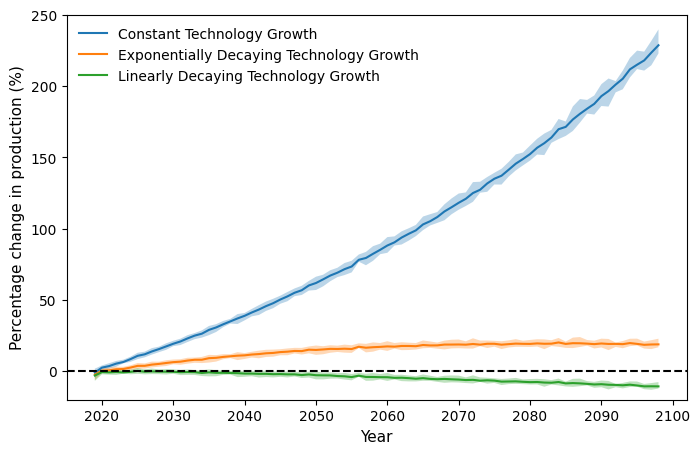

In [25]:
#Example of full hostorical data (1961 - 2018)
combined_data_production_percent_change_wheat = combined_data_production_percent_change['wheat']

average_RCP85_fixed_AllSample = combined_data_production_percent_change_wheat['average_results']['85']['const']
quantile_RCP85_fixed_AllSample_25 = combined_data_production_percent_change_wheat['quantile_25_results']['85']['const']
quantile_RCP85_fixed_AllSample_75 = combined_data_production_percent_change_wheat['quantile_75_results']['85']['const']   

average_RCP85_TVa0_Exp = combined_data_production_percent_change_wheat['average_results']['85']['exp']
quantile_RCP85_TVa0_Exp_25 = combined_data_production_percent_change_wheat['quantile_25_results']['85']['exp']
quantile_RCP85_TVa0_Exp_75 = combined_data_production_percent_change_wheat['quantile_75_results']['85']['exp'] 

average_RCP85_TVa0_Linear = combined_data_production_percent_change_wheat['average_results']['85']['lin']
quantile_RCP85_TVa0_Linear_25 = combined_data_production_percent_change_wheat['quantile_25_results']['85']['lin']
quantile_RCP85_TVa0_Linear_75 = combined_data_production_percent_change_wheat['quantile_75_results']['85']['lin'] 


# Plot - the last subplot in Figure 1
fig, ax = plt.subplots(figsize=(8, 5))

# Plot mean
average_RCP85_fixed_AllSample.plot(ax=ax, label='Constant Technology Growth', marker='', linestyle='-')
ax.fill_between(average_RCP85_fixed_AllSample.index, quantile_RCP85_fixed_AllSample_25, quantile_RCP85_fixed_AllSample_75, alpha=0.3)
average_RCP85_TVa0_Exp.plot(ax=ax, label='Exponentially Decaying Technology Growth', marker='', linestyle='-')
ax.fill_between(average_RCP85_TVa0_Exp.index, quantile_RCP85_TVa0_Exp_25, quantile_RCP85_TVa0_Exp_75, alpha=0.3)
average_RCP85_TVa0_Linear.plot(ax=ax, label='Linearly Decaying Technology Growth', marker='', linestyle='-')
ax.fill_between(average_RCP85_TVa0_Linear.index, quantile_RCP85_TVa0_Linear_25, quantile_RCP85_TVa0_Linear_75, alpha=0.3)

line_RCP85_fixed_AllSample = ax.lines[-3] 
line_RCP85_TVa0_Exp = ax.lines[-2]
line_RCP85_TVa0_Linear = ax.lines[-1]
# Create proxies for the line plots
line_legend_RCP85_fixed_AllSample = Line2D([0], [0], color=line_RCP85_fixed_AllSample.get_color(), lw=2)  
line_legend_RCP85_TVa0_Exp = Line2D([0], [0], color=line_RCP85_TVa0_Exp.get_color(), lw=2)  
line_legend_RCP85_TVa0_Linear = Line2D([0], [0], color=line_RCP85_TVa0_Linear.get_color(), lw=2)  


# Draw a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--')

# Customize plot
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Percentage change in production (%)', fontsize=11)

ax.legend(framealpha=0.0)

ax.set_ylim(-20, 250)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

# Projection Results in Figure 2 (Wheat)

In [26]:
#Test - identify significant points
def find_significant_time_points(difference_RCP26, difference_RCP45, difference_RCP85):
    time_points = difference_RCP26.index.tolist()
    significant_time_points = []  # to store the time points where p-value < 0.05 in the F-test

    # Define all combinations of distributions for pairwise tests
    combinations = list(itertools.combinations(["RCP26", "RCP45", "RCP85"], 2))

    # Create dictionaries to store significant and insignificant time points for each pair
    significant_time_points_dict = {pair: [] for pair in combinations}
    insignificant_time_points_dict = {pair: [] for pair in combinations}
    num_significant_pvalues_dict = {pair: 0 for pair in combinations}

    for time_point in time_points:
        # Extract the distributions for the time point
        distribution1 = difference_RCP26.loc[time_point, :].values
        distribution2 = difference_RCP45.loc[time_point, :].values
        distribution3 = difference_RCP85.loc[time_point, :].values

        # Combine all distributions into a single array
        data = np.concatenate([distribution1, distribution2, distribution3])

        # Create labels for the data
        labels = ['RCP26'] * len(distribution1) + ['RCP45'] * len(distribution2) + ['RCP85'] * len(distribution3)

        # Combine the data and labels into a DataFrame for the ANOVA test
        df = pd.DataFrame({'values': data, 'group': labels})

        # Perform the ANOVA test using the F-test
        model = ols('values ~ C(group)', data=df).fit()
        anova_result = stats.f_oneway(distribution1, distribution2, distribution3)

        # Perform Tukey HSD test only if the F-test is significant
        if anova_result.pvalue < 0.05:
            significant_time_points.append(time_point)
            tukey_result = pairwise_tukeyhsd(data, labels)
            
            # Get the p-values from the Tukey HSD result
            pvals = tukey_result.pvalues

            # Update the significant and insignificant time points dictionaries
            for idx, pair in enumerate(combinations):
                if pvals[idx] < 0.05:
                    significant_time_points_dict[pair].append(time_point)
                    num_significant_pvalues_dict[pair] += 1
                else:
                    insignificant_time_points_dict[pair].append(time_point)

    return significant_time_points_dict



In [27]:
def plot_mean_with_quantiles(ax, data_dict, rcp_index, model_version, label):
    """
    Plot mean and quantile ranges for the given RCP scenario and model version.

    Parameters:
    - ax: The axis to plot on.
    - data_dict: Dictionary containing average and quantile data.
    - rcp_index: RCP scenario number as a string (e.g., '26').
    - model_version: Model version key as a string (e.g., 'const', 'exp').
    - label: Label for the line plot.
    """
    
    average = data_dict['average_results'][rcp_index][model_version]
    quantile_25 = data_dict['quantile_25_results'][rcp_index][model_version]
    quantile_75 = data_dict['quantile_75_results'][rcp_index][model_version]

    average.plot(ax=ax, label=label, marker='', linestyle='-')
    ax.fill_between(average.index, quantile_25, quantile_75, alpha=0.3)

    return ax.lines[-1]

def mark_significant_points(ax, significant_time_points, data, color, size=20):
    """
    Mark significant time points on the plot.

    Parameters:
    - ax: The axis to plot on.
    - significant_time_points: List of time points to mark as significant.
    - data: Data corresponding to the RCP scenario.
    - color: Color for the markers.
    - size: Size of the markers.
    """
    for time_point in significant_time_points:
        ax.scatter(time_point, data[time_point], color=color, zorder=5, s=size)

def create_legend(ax, lines, labels, fontsize):
    """
    Create a legend on the plot.

    Parameters:
    - ax: The axis to plot on.
    - lines: List of line objects for the legend.
    - labels: List of labels corresponding to the lines.
    """
    return ax.legend(lines, labels, loc='lower left', fontsize=fontsize, bbox_to_anchor=(0, 0.55), borderaxespad=0.0, ncol=1, framealpha=0.05)

# Pre-process significant time points outside the function
def preprocess_significant_time_points(crop, model_versions):
    significant_points = {}
    combined_data = combined_data_production_percent_change[crop]
    for model_version in model_versions:
        significant_points.update({
            (model_version): find_significant_time_points(
                combined_data['difference_results']['26'][model_version],
                combined_data['difference_results']['45'][model_version],
                combined_data['difference_results']['85'][model_version]
            )
        })
    return significant_points



In [28]:
def plot_results(ax, crop, rcp_index, model_versions, pair, significance_label, legend_labels, ylim_values, preprocessed_significant_points, significance_color, fontsize):
    """
    Main function to plot the results for different RCP scenarios and model versions.

    Parameters:
    - ax: The axis object on which the plots will be drawn. 
    - crop: Crop type (e.g., 'wheat').
    - rcp_index: The RCP scenario for the current plot
    - model_versions: List of intercept versions corresponding to each RCP scenario (e.g., ['const', 'const_recent', 'exp', 'lin']).
    - pair: Tuple of RCP scenarios to compare (e.g., ('RCP26', 'RCP45')).
    - significance_label: Label for the significance marker.
    - legend_labels: List of labels for the legend.
    - ylim_values: Tuple for setting y-axis limits (e.g., (-20, 290)).
    - preprocessed_significant_points: Dictionary of preprocessed significant time points.
    - significance_color: color of significant points.
    - fontsize: An integer specifying the font size for axis labels and ticks.
    """
    
    # Access the data for the given crop
    combined_data = combined_data_production_percent_change[crop]

    # Plot data for each RCP scenario and model version
    lines = []
    for model_version, label in zip(model_versions, legend_labels):
        line = plot_mean_with_quantiles(ax, combined_data, rcp_index, model_version, label)
        lines.append(line)

    # Mark significant time points
    for model_version in model_versions:
        significant_time_points = preprocessed_significant_points.get(model_version, [])
        #mark_significant_points(ax, significant_time_points.get(pair, []), combined_data['average_results'][crop][rcp_index][model_version], significance_color)
        mark_significant_points(ax, significant_time_points.get(pair, []), combined_data['average_results'][rcp_index][model_version], significance_color)
    
    # Add a label for the significance markers
    ax.scatter([], [], color=significance_color, label=significance_label)

    # Draw a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--')

    # Customize plot
    ax.set_xlabel('Year', fontsize=fontsize)
    ax.set_ylabel('Percentage Change (%)', fontsize=fontsize)
    ax.set_ylim(ylim_values)

    # Create legend
    if rcp_index == '26':
        create_legend(ax, lines + [ax.collections[-1]], legend_labels + [significance_label], fontsize)
    else:
        create_legend(ax, [ax.collections[-1]], [significance_label], fontsize)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    

In [29]:
def plot_data_one_scenario(ax, average_data, quantile_25, quantile_75, label_prefix):
    """
    Plot the average data with shaded quantile ranges.
    
    Parameters:
        ax: The matplotlib axes object.
        average_data: Dictionary of average data for different scenarios.
        quantile_25: Dictionary of 25th percentile quantiles for different scenarios.
        quantile_75: Dictionary of 75th percentile quantiles for different scenarios.
        label_prefix: Prefix used for labeling the data series.
    """
    for scenario, data in average_data.items():
        data.plot(ax=ax, label=f'{label_prefix}{scenario}', marker='', linestyle='-')
        ax.fill_between(data.index, quantile_25[scenario], quantile_75[scenario], alpha=0.3)
    
    # Create proxies for the line plots
    lines = ax.get_lines()
    line_proxies = [Line2D([0], [0], color=line.get_color(), lw=2) for line in lines[-len(average_data):]]
    return line_proxies

def plot_significant_points_one_scenario(ax, significant_points, average_data):
    """
    Plot significant points on the graph.
    
    Parameters:
        ax: The matplotlib axes object.
        significant_points: Dictionary of significant points for different pairs.
        average_data: Dictionary of average data for different scenarios.
    """
    scatter_proxies = []
    colors = {'RCP2.6-RCP8.5 Significance': 'green', 'RCP4.5-RCP8.5 Significance': 'blue', 'RCP2.6-RCP4.5 Significance': 'red'}
    
    for pair, color in colors.items():
        relevant_lines = {
            '85': pair == "RCP2.6-RCP8.5 Significance",
            '45': pair == "RCP4.5-RCP8.5 Significance",
            '26': pair == "RCP2.6-RCP4.5 Significance"
        }
        
        for scenario, show_points in relevant_lines.items():
            if show_points:
                if pair in significant_points:
                    for time_point in significant_points[pair]:
                        if time_point in average_data[scenario].index:
                            ax.scatter(time_point, average_data[scenario].loc[time_point], color=color, zorder=5, s=20)
                scatter_proxies.append(ax.scatter([], [], color=color, label=pair, s=20))
    
    return scatter_proxies

def create_plot_production_one_scenario(average_data, quantile_25, quantile_75, significant_points, title, ylim, ax, fontsize,case_type):
    """
    Create and customize the plot for a given scenario.
    
    Parameters:
        average_data: Dictionary of average data for different scenarios.
        quantile_25: Dictionary of 25th percentile quantiles for different scenarios.
        quantile_75: Dictionary of 75th percentile quantiles for different scenarios.
        significant_points: Dictionary of significant points to plot.
        title: Title of the plot.
        ylim: Tuple specifying the y-axis limits.
        ax: The matplotlib axes object.
        case_type: Intercept case type to determine if legends should be included.
    """
    # Plot data
    line_proxies = plot_data_one_scenario(ax, average_data, quantile_25, quantile_75, '')
    
    # Draw horizontal line
    ax.axhline(y=0, color='black', linestyle='--')
    
    # Plot significant points
    scatter_proxies = plot_significant_points_one_scenario(ax, significant_points, average_data)
    
    # Customize plot
    ax.set_xlabel('Year', fontsize=fontsize)
    ax.set_ylabel('Percentage Change (%)', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_ylim(ylim)
    ax.tick_params(axis='x', labelsize=fontsize)
    plt.yticks(fontsize=fontsize)
    

    # Create legend
    if case_type == 'exp':
        ax.legend(scatter_proxies + line_proxies, [p.get_label() for p in scatter_proxies] + [f'RCP{r}' for r in average_data], 
                  loc='lower left', fontsize=fontsize, bbox_to_anchor=(0.01, 0.55), borderaxespad=0.0, ncol=1, framealpha=0.0)
    else:
        ax.legend(scatter_proxies, [p.get_label() for p in scatter_proxies], 
                  loc='lower left', fontsize=fontsize, bbox_to_anchor=(0.01, 0.75), borderaxespad=0.0, ncol=1, framealpha=0.0)

# Define data dictionaries
def prepare_data(case_type, combined_data, crop):
    
    average_data = {
        '85': combined_data['average_results']['85'][case_type],
        '45': combined_data['average_results']['45'][case_type],
        '26': combined_data['average_results']['26'][case_type]
    }
    quantile_25 = {
        '85': combined_data['quantile_25_results']['85'][case_type],
        '45': combined_data['quantile_25_results']['45'][case_type],
        '26': combined_data['quantile_25_results']['26'][case_type]
    }
    quantile_75 = {
        '85': combined_data['quantile_75_results']['85'][case_type],
        '45': combined_data['quantile_75_results']['45'][case_type],
        '26': combined_data['quantile_75_results']['26'][case_type]
    }
    return average_data, quantile_25, quantile_75

# Define significant points and colors
def get_significant_points(case_type,preprocessed_significant_points):
    return {
        'RCP2.6-RCP8.5 Significance': preprocessed_significant_points[case_type][("RCP26", "RCP85")],
        'RCP4.5-RCP8.5 Significance': preprocessed_significant_points[case_type][("RCP45", "RCP85")],
        'RCP2.6-RCP4.5 Significance': preprocessed_significant_points[case_type][("RCP26", "RCP45")]
    }

In [30]:
# This will take approximately 1 minute

crop = 'wheat'
rcp_numbers=['26', '45', '85']
model_versions=['const', 'const_recent', 'exp', 'lin']
preprocessed_significant_points = preprocess_significant_time_points(crop, model_versions)


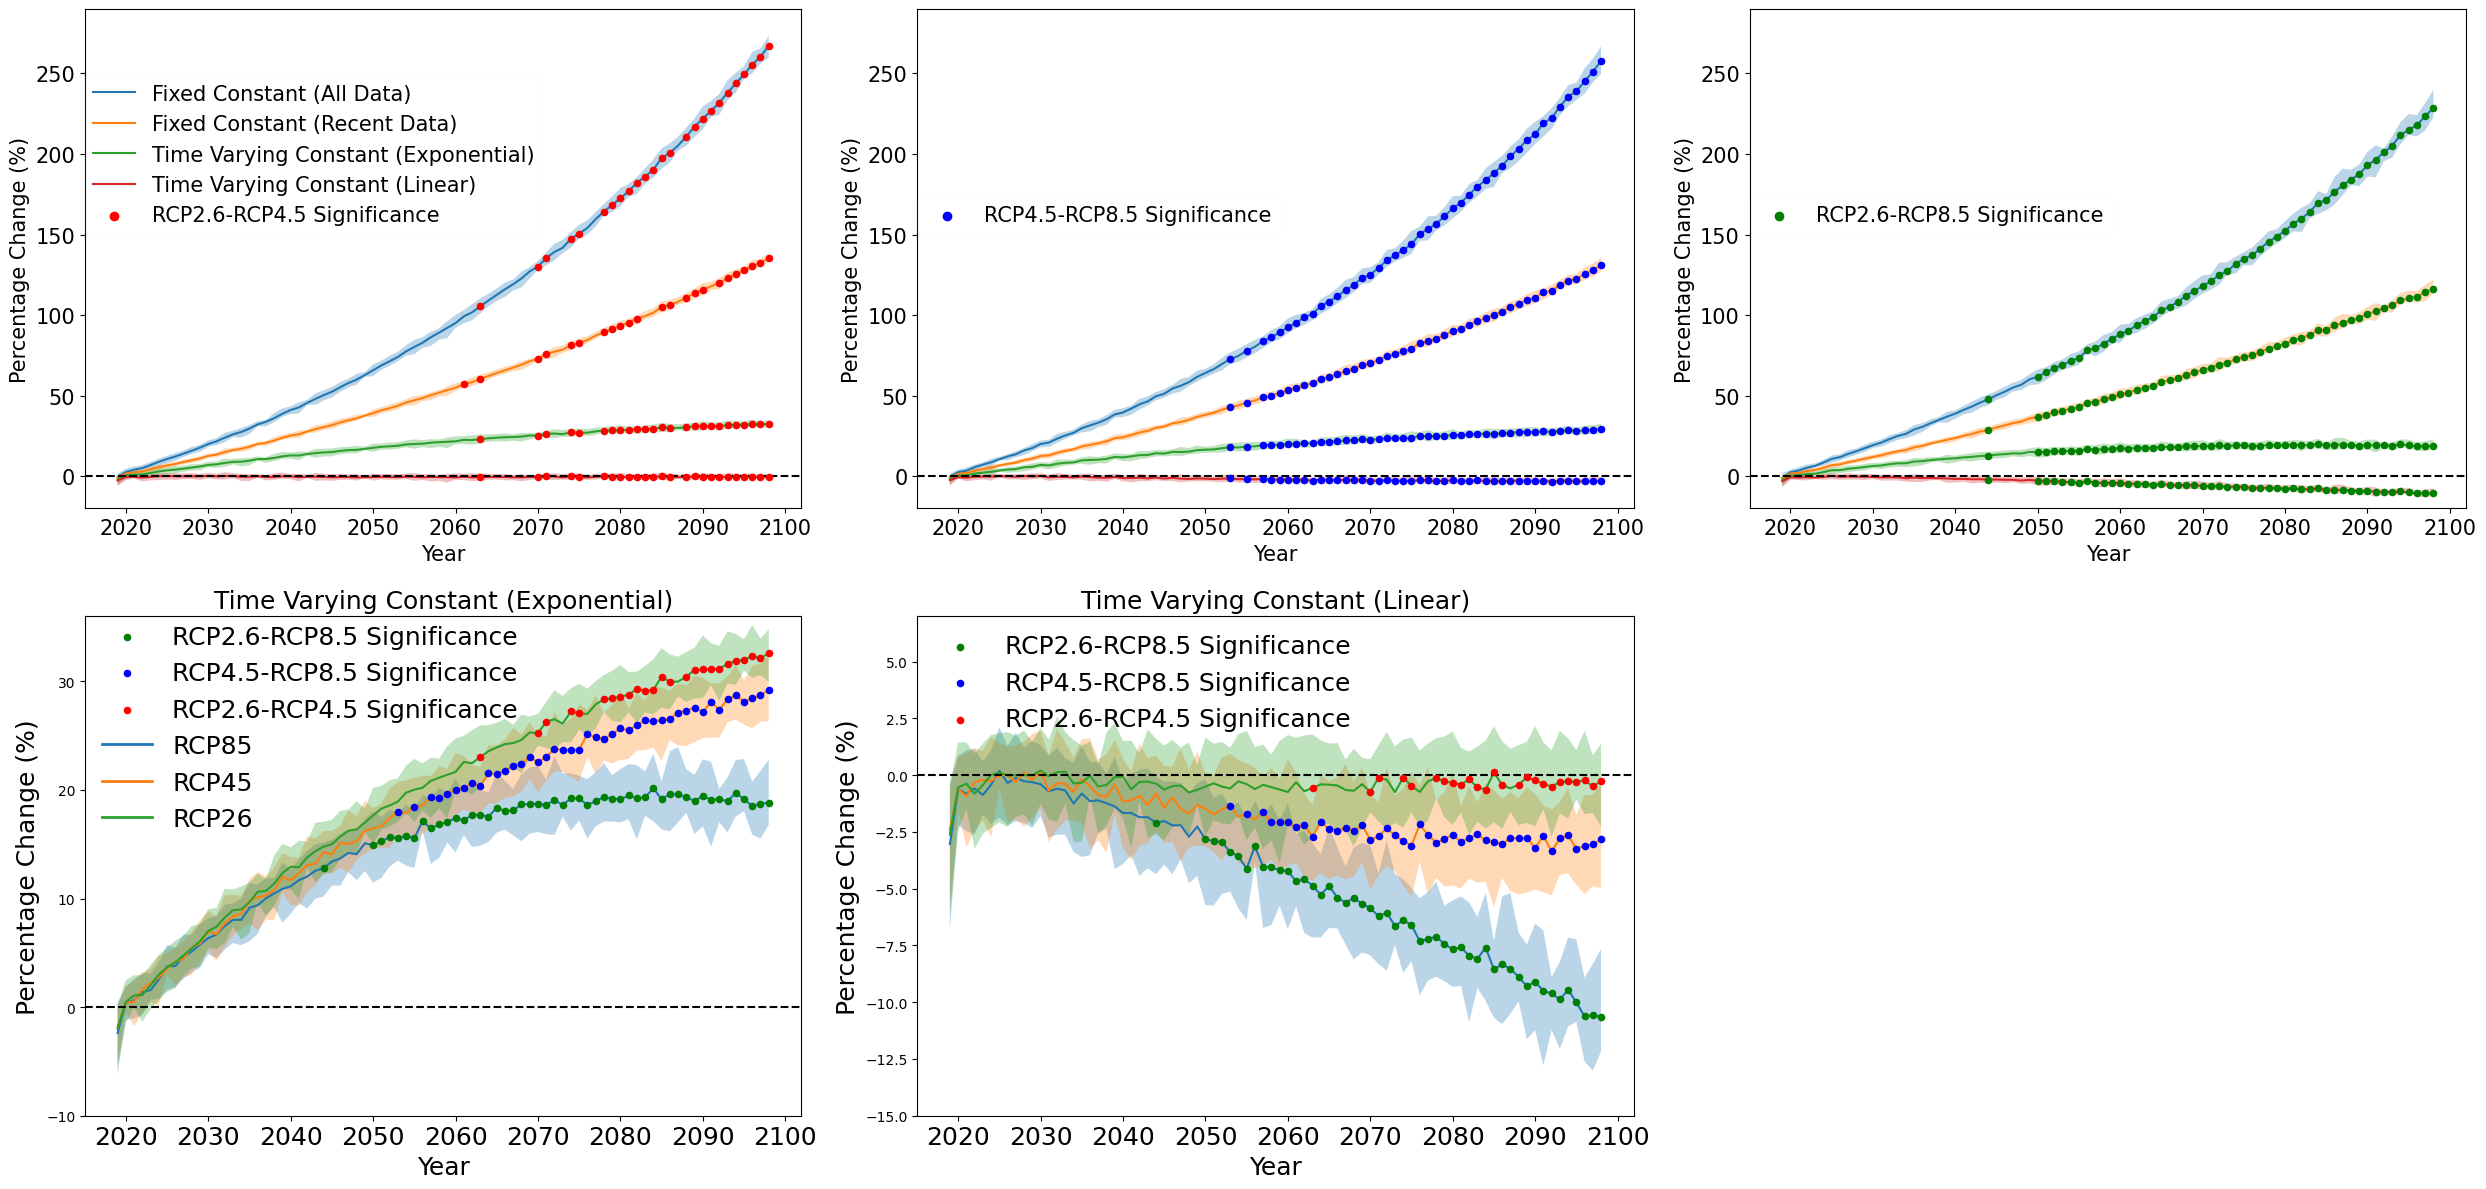

In [31]:
# Create the figure and three subplots arranged in one row
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 12))  

crop = 'wheat'
combined_data = combined_data_production_percent_change[crop]

# RCP2.6:
plot_results(
    ax=ax1,
    crop='wheat',
    rcp_index='26',
    model_versions=['const', 'const_recent', 'exp', 'lin'], 
    pair=('RCP26', 'RCP45'), 
    significance_label='RCP2.6-RCP4.5 Significance',
    legend_labels=[
        'Fixed Constant (All Data)', 
        'Fixed Constant (Recent Data)', 
        'Time Varying Constant (Exponential)', 
        'Time Varying Constant (Linear)'
    ],
    ylim_values=(-20, 290),
    preprocessed_significant_points=preprocessed_significant_points,
    significance_color='red',
    fontsize=15
)

# RCP4.5:
plot_results(
    ax=ax2,
    crop='wheat', 
    rcp_index='45',
    model_versions=['const', 'const_recent', 'exp', 'lin'], 
    pair=('RCP45', 'RCP85'), 
    significance_label='RCP4.5-RCP8.5 Significance',
    legend_labels=[
        'Fixed Constant (All Data)', 
        'Fixed Constant (Recent Data)', 
        'Time Varying Constant (Exponential)', 
        'Time Varying Constant (Linear)'
    ],
    ylim_values=(-20, 290),
    preprocessed_significant_points=preprocessed_significant_points,
    significance_color='blue',
    fontsize=15
)

# RCP8.5:
plot_results(
    ax=ax3,
    crop='wheat', 
    rcp_index='85',
    model_versions=['const', 'const_recent', 'exp', 'lin'], 
    pair=('RCP26', 'RCP85'), 
    significance_label='RCP2.6-RCP8.5 Significance',
    legend_labels=[
        'Fixed Constant (All Data)', 
        'Fixed Constant (Recent Data)', 
        'Time Varying Constant (Exponential)', 
        'Time Varying Constant (Linear)'
    ],
    ylim_values=(-20, 290),
    preprocessed_significant_points=preprocessed_significant_points,
    significance_color='green',
    fontsize=15
)


for case_type, title, ylim in [('exp', 'Time Varying Constant (Exponential)', (-10, 36))]:
    average_data, quantile_25, quantile_75 = prepare_data(case_type, combined_data, crop)
    significant_points = get_significant_points(case_type,preprocessed_significant_points)
    
    create_plot_production_one_scenario(average_data, quantile_25, quantile_75, significant_points, title, ylim, ax4, fontsize=18, case_type=case_type)
    
for case_type, title, ylim in [('lin', 'Time Varying Constant (Linear)', (-15, 7))]:
    average_data, quantile_25, quantile_75 = prepare_data(case_type, combined_data, crop)
    significant_points = get_significant_points(case_type,preprocessed_significant_points)
    
    create_plot_production_one_scenario(average_data, quantile_25, quantile_75, significant_points, title, ylim, ax5, fontsize=18, case_type=case_type)
    
# Hide the last subplot (ax6)
ax6.set_visible(False)  # This hides the subplot but keeps its space

# Adjust layout and show the plot
plt.subplots_adjust(wspace=0.25)  # Adjusted spacing between subplots
plt.tight_layout()
plt.show()


# Model Selection

In [32]:


def expand_fitting_model_selection(Model, start_sample_size, full_sample_size, country_num, entity_dummies, tr_dummies, entities,
                                   data_model_selection_Eq10, data_model_selection_FE_Eq9, data_model_selection_marx):
    
    """
    Expand the model fitting process by iteratively increasing the sample size and fitting various models.
    
    Parameters:
    - Model: The model type to be used ('FE_return': Eq(9) in the paper, 'FE': Eq(10), 'MARX': Eq(5), 'MARX_raw': Eq(12), 'MARX_FE': Eq(11)).
    - start_sample_size: Initial sample size for the fitting process.
    - full_sample_size: The full sample size to be used in the iteration.
    - country_num: Number of countries in the dataset.
    - entity_dummies: Entity dummy variables used in the model.
    - tr_dummies: Time-region dummy variables used in the model.
    - entities: List of entities (e.g., countries).
    - data_model_selection_Eq10: Data used for FE_return model.
    - data_model_selection_FE_Eq9: Data used for FE model.
    - data_model_selection_marx: Data used for MARX-type models.
    
    Returns:
    - all_fitting_results: Dictionary containing the fitting results, residuals, RMSE, AIC, and BIC for each model and sample size.
    """

    all_fitting_results = {}
    sample_size = range(start_sample_size, full_sample_size)

    def prepare_data(data, Model, time_var='Time'):
        if Model == 'FE':
            data_fit = data.iloc[:(ii+2+1)*country_num]
        else:
            data_fit = data.iloc[:(ii+2)*country_num]
        time_dummies = pd.get_dummies(data_fit[time_var], prefix=time_var, drop_first=True)
        return pd.concat([data_fit, time_dummies], axis=1)

    def calculate_residuals(observed, predicted):
        if isinstance(observed, pd.DataFrame) or isinstance(observed, pd.Series):
            observed = observed.to_numpy()
        if isinstance(predicted, pd.DataFrame) or isinstance(predicted, pd.Series):
            predicted = predicted.to_numpy()
        return observed - predicted

    def calculate_rmse(residuals):
        return np.sqrt(np.mean(residuals ** 2))

    def calculate_aic_bic(n_obs, residuals, n_params):
        log_likelihood = -(n_obs * 1/2) * (1 + np.log(2 * np.pi)) - (n_obs / 2) * np.log(residuals.dot(residuals) / n_obs)
        aic_value = -2 * log_likelihood + 2 * n_params
        bic_value = -2 * log_likelihood + n_params * np.log(n_obs)
        return aic_value, bic_value

    def fit_ols_model(exog, endog, cov_type='cluster', cluster_entity=None):
        model_ols = sm.OLS(endog, exog).fit(cov_type=cov_type, cov_kwds={'groups': cluster_entity})
        return model_ols

    def fit_panel_model(formula, data_with_dummies, cov_type='clustered', cluster_entity=True):
        model = PanelOLS.from_formula(formula, data=data_with_dummies)
        return model, model.fit(cov_type=cov_type, cluster_entity=cluster_entity)

    for ii in sample_size:
        if Model in ['FE_return', 'FE']:
            tr_dummies_fit = ' + '.join([f'TR{i}' for i in range(2, country_num + 1)])
            tr2_dummies_fit = ' + '.join([f'T2R{i}' for i in range(2, country_num + 1)])
            time_dummies_fit = ' + '.join([f'Time_{i}' for i in range(2, ii + 2 + 1)])
            
            data_type = {
                'FE_return': data_model_selection_Eq10,
                'FE': data_model_selection_FE_Eq9
            }[Model]
            
            data_with_dummies = prepare_data(data_type, Model)
            formula_base = {
                'FE_return': f'y_logR ~ 1 + {entity_dummies} + x1 + x2 + x3 + x4 + {tr_dummies_fit} + {tr2_dummies_fit} + {time_dummies_fit}',
                'FE': f'y ~ 1 + {entity_dummies} + x1 + x2 + x3 + x4 + {tr_dummies}'
            }[Model]

            result = fit_panel_model(formula_base, data_with_dummies)
            model = result[0]
            result = result[1]

            # Collect results
            predicted_values = result.predict()
            observed_values_df = result.model.dependent.dataframe
            if Model == 'FE':
                residuals = ((observed_values_df.values)[country_num:] - (observed_values_df.values)[:-country_num]) - ((predicted_values.values)[country_num:] - (predicted_values.values)[:-country_num])
                n_obs = result.nobs  - 1*country_num
            else:
                residuals = observed_values_df.values - predicted_values.values
                n_obs = result.nobs 
            
            rmse = calculate_rmse(residuals)
         
            n_params = result.params.shape[0]
            aic, bic = calculate_aic_bic(n_obs, residuals.ravel(), n_params)

            all_fitting_results[f'data_InSample_{Model}_{ii}'] = data_with_dummies
            all_fitting_results[f'model_result_{Model}_{ii}'] = result
            all_fitting_results[f'residuals_{Model}_{ii}'] = residuals
            all_fitting_results[f'rmse_{Model}_{ii}'] = rmse
            all_fitting_results[f'AIC_{Model}_{ii}'] = aic
            all_fitting_results[f'BIC_{Model}_{ii}'] = bic

            if ii < full_sample_size - 1:
                if Model == 'FE':
                    data_test = data_model_selection_FE_Eq9.iloc[(ii+2+1)*country_num:(ii+1+2+1)*country_num]
                    params = result.params
                    time_dummies_test = pd.get_dummies(data_test['Time'], prefix='Time', drop_first=True)
                    data_with_dummies_test = pd.concat([data_test, time_dummies_test], axis=1)
                    tr_variables_test = [f'TR{i}' for i in range(1, country_num + 1)]
                    constant_test = [1] * country_num
                    exog_test= pd.DataFrame(columns= ['constant'] + entities+['x1', 'x2', 'x3', 'x4'] + tr_variables_test)
                    exog_test[entities] = data_with_dummies_test[entities].copy()
                    exog_test['constant'] = constant_test
                    exog_test['x1'] = data_with_dummies_test['x1'].copy()
                    exog_test['x2'] = data_with_dummies_test['x2'].copy()
                    exog_test['x3'] = data_with_dummies_test['x3'].copy()
                    exog_test['x4'] = data_with_dummies_test['x4'].copy()
                    exog_test[tr_variables_test] = data_with_dummies_test[tr_variables_test].copy()
                    endog_test = data_with_dummies_test['y'].values 
                    
                    predictions = model.predict(params, exog=exog_test)
                    # Concatenate into a single large array
                    predictions = np.concatenate(predictions.values, axis=0)
                    result_df = pd.concat([
                        exog_test.reset_index(),
                        pd.Series(predictions.flatten(), name='predicted_variable'),
                        pd.Series(endog_test.flatten(), name='observed_variable')
                    ], axis=1)
                    Yield_previous = (data_with_dummies['y'].values)[-country_num:]
                    squared_residuals = ((endog_test - Yield_previous) - (predictions - Yield_previous)) ** 2

                    all_fitting_results[f'data_OutSample_{Model}_{ii}'] = data_test
                    all_fitting_results[f'exog_predict_{Model}_{ii}'] = result_df
                    all_fitting_results[f'error_predict_{Model}_{ii}'] = squared_residuals

        elif Model in ['MARX', 'MARX_raw']:
            if Model == 'MARX':
                exog_train = pd.DataFrame({
                    'constant': [1]*(ii*country_num),
                    'T': data_model_selection_marx.iloc[:ii*country_num]['x1'].values,
                    'T2': data_model_selection_marx.iloc[:ii*country_num]['x2'].values,
                    'P': data_model_selection_marx.iloc[:ii*country_num]['x3'].values,
                    'P2': data_model_selection_marx.iloc[:ii*country_num]['x4'].values,
                    'yield_lag1': data_model_selection_marx.iloc[:ii*country_num]['yield_LogR_lag1'].values,
                    'yield_lag2': data_model_selection_marx.iloc[:ii*country_num]['yield_LogR_lag2'].values,
                })
            else:
                exog_train = pd.DataFrame({
                    'constant': [1] * (ii * country_num),
                    'T': data_model_selection_marx.iloc[:ii * country_num]['T'].values,
                    'T2': data_model_selection_marx.iloc[:ii * country_num]['T2'].values,
                    'P': data_model_selection_marx.iloc[:ii * country_num]['P'].values,
                    'P2': data_model_selection_marx.iloc[:ii * country_num]['P2'].values,
                    'yield_lag1': data_model_selection_marx.iloc[:ii * country_num]['yield_LogR_lag1'].values,
                    'yield_lag2': data_model_selection_marx.iloc[:ii * country_num]['yield_LogR_lag2'].values,
                })
            endog_train = data_model_selection_marx.iloc[:ii * country_num]['yield_LogR'].values
            model_ols = fit_ols_model(exog_train, endog_train, cov_type='cluster', cluster_entity=data_model_selection_marx.iloc[:ii * country_num]['Country'])

            residuals = calculate_residuals(pd.Series(endog_train), model_ols.predict(exog_train))
            rmse = calculate_rmse(residuals)
            n_obs = model_ols.nobs
            n_params = model_ols.params.shape[0]
            aic, bic = calculate_aic_bic(n_obs, residuals.ravel(), n_params)

            all_fitting_results[f'data_InSample_{Model}_{ii}'] = exog_train
            all_fitting_results[f'model_result_{Model}_{ii}'] = model_ols
            all_fitting_results[f'residuals_{Model}_{ii}'] = residuals
            all_fitting_results[f'rmse_{Model}_{ii}'] = rmse
            all_fitting_results[f'AIC_{Model}_{ii}'] = aic
            all_fitting_results[f'BIC_{Model}_{ii}'] = bic

            if ii < full_sample_size - 1:
                if Model == 'MARX':
                    exog_test = pd.DataFrame({
                        'constant': [1]*(country_num),
                        'T': data_model_selection_marx.iloc[ii*country_num:(ii+1)*country_num]['x1'].values,
                        'T2': data_model_selection_marx.iloc[ii*country_num:(ii+1)*country_num]['x2'].values,
                        'P': data_model_selection_marx.iloc[ii*country_num:(ii+1)*country_num]['x3'].values,
                        'P2': data_model_selection_marx.iloc[ii*country_num:(ii+1)*country_num]['x4'].values,
                        'yield_lag1': data_model_selection_marx.iloc[ii*country_num:(ii+1)*country_num]['yield_LogR_lag1'].values,
                        'yield_lag2': data_model_selection_marx.iloc[ii*country_num:(ii+1)*country_num]['yield_LogR_lag2'].values,
                    })
                else:
                    exog_test = pd.DataFrame({
                        'constant': [1] * country_num,
                        'T': data_model_selection_marx.iloc[ii * country_num:(ii + 1) * country_num]['T'].values,
                        'T2': data_model_selection_marx.iloc[ii * country_num:(ii + 1) * country_num]['T2'].values,
                        'P': data_model_selection_marx.iloc[ii * country_num:(ii + 1) * country_num]['P'].values,
                        'P2': data_model_selection_marx.iloc[ii * country_num:(ii + 1) * country_num]['P2'].values,
                        'yield_lag1': data_model_selection_marx.iloc[ii * country_num:(ii + 1) * country_num]['yield_LogR_lag1'].values,
                        'yield_lag2': data_model_selection_marx.iloc[ii * country_num:(ii + 1) * country_num]['yield_LogR_lag2'].values,
                    })
                endog_test = data_model_selection_marx.iloc[ii * country_num:(ii + 1) * country_num]['yield_LogR'].values
                
                predictions = model_ols.predict(exog_test)
                result_df = pd.concat([
                    exog_test.reset_index(),
                    pd.Series(predictions, name='predicted_variable'),
                    pd.Series(endog_test.flatten(), name='observed_variable')
                ], axis=1)
                
                all_fitting_results[f'data_OutSample_{Model}_{ii}'] = pd.DataFrame(exog_test)
                all_fitting_results[f'exog_predict_{Model}_{ii}'] = result_df
                all_fitting_results[f'error_predict_{Model}_{ii}'] = (calculate_residuals(endog_test, predictions))**2
        
        elif Model == 'MARX_FE': #Eq(11) in the paper   
            data_fit_MARX_FE = data_model_selection_marx.iloc[:ii*country_num]
            data_fit_MARX_FE = pd.DataFrame(data_fit_MARX_FE)
            data_fit_MARX_FE['Year'] = data_fit_MARX_FE['Year'].astype(int)
            data_fit_MARX_FE.set_index(['Country','Year'], inplace=True)
            
            formula = f'yield_LogR ~ 1 + x1 + x2 + x3 + x4 + yield_LogR_lag1 + yield_LogR_lag2 + {entity_dummies}'
            model = PanelOLS.from_formula(formula, data = data_fit_MARX_FE)
            result = model.fit(cov_type='clustered', cluster_entity=True)
            
            observed_values = result.model.dependent
            observed_values_df = observed_values.dataframe
            residuals = calculate_residuals(observed_values_df.values, result.predict())
            rmse = calculate_rmse(residuals)
            n_obs = result.nobs
            n_params = result.params.shape[0]
            aic, bic = calculate_aic_bic(n_obs, residuals.ravel(), n_params)
            
            # Save results in the dictionary
            all_fitting_results[f'data_InSample_{Model}_{ii}'] = data_fit_MARX_FE
            all_fitting_results[f'model_result_{Model}_{ii}'] = result
            all_fitting_results[f'residuals_{Model}_{ii}'] = residuals
            all_fitting_results[f'rmse_{Model}_{ii}'] = rmse
            all_fitting_results[f'AIC_{Model}_{ii}'] = aic
            all_fitting_results[f'BIC_{Model}_{ii}'] = bic
            
            if ii < full_sample_size - 1:
            ####One-step-ahead Forecast####:
                params = result.params
                data_test_MARX_FE = data_model_selection_marx.iloc[ii*country_num:(ii+1)*country_num]
                data_test_MARX_FE = pd.DataFrame(data_test_MARX_FE)
                data_test_MARX_FE['Year'] = data_test_MARX_FE['Year'].astype(int)
                data_test_MARX_FE.set_index(['Country','Year'], inplace=True)
                exog_test = {}
                constant_test = [1]*(country_num)
                exog_test['constant'] = constant_test
                exog_test= pd.DataFrame(exog_test)
                exog_test['x1'] = data_test_MARX_FE['x1'].values
                exog_test['x2'] = data_test_MARX_FE['x2'].values
                exog_test['x3'] = data_test_MARX_FE['x3'].values
                exog_test['x4'] = data_test_MARX_FE['x4'].values
                exog_test['yield_LogR_lag1'] = data_test_MARX_FE['yield_LogR_lag1'].values
                exog_test['yield_LogR_lag2'] = data_test_MARX_FE['yield_LogR_lag2'].values
                exog_test[entities] = data_test_MARX_FE[entities].values
                exog_test = exog_test.set_index(data_test_MARX_FE.index)
                endog_test = data_test_MARX_FE['yield_LogR'].values 
                
                predictions = model.predict(params, exog=exog_test)
                large_array = np.concatenate(predictions.values, axis=0)
                
                exog_test_reset = exog_test.reset_index()
                # Concatenate into a single large DataFrame
                result_df = pd.concat([exog_test_reset, pd.Series(large_array.flatten(), name='predicted_variable'), pd.Series(endog_test.flatten(), name='observed_variable')], axis=1)
                                
                all_fitting_results[f'data_OutSample_{Model}_{ii}'] = exog_test
                all_fitting_results[f'exog_predict_{Model}_{ii}'] = result_df
                all_fitting_results[f'error_predict_{Model}_{ii}'] = (endog_test - large_array)**2
        
    return all_fitting_results


In [33]:
#Required information for model selection (example of wheat):

entities = ['Peru', 'Tanzania', 'Albania', 'Algeria', 'Bangladesh', 'Bolivia', 'Bulgaria', 'Denmark',
                'Egypt', 'France', 'Germany', 'Hungary', 'India', 'Iran', 'Iraq', 'Israel', 'Japan', 'Lebanon',
                'Libya', 'Mexico', 'Morocco', 'Myanmar', 'Nepal', 'Pakistan', 'Poland', 'Romania', 'SaudiArabia',
                'SouthKorea', 'Spain', 'Sweden', 'Syria', 'Tunisia', 'UnitedKingdom', 'Canada', 'China', 'Italy',
                'NorthKorea', 'Turkey', 'UnitedStates', 'Zimbabwe', 'Australia', 'Colombia', 'Ecuador', 'Guatemala',
                'Kenya', 'Angola', 'Argentina', 'Brazil', 'Chile', 'Lesotho', 'Mozambique', 'Namibia',
                'Paraguay', 'SouthAfrica']

# Create dummy variables for each entity and join them into a string
entity_dummies = ' + '.join([f'{entity}' for entity in entities])
country_num = 55
tr_variables = [f'TR{i}' for i in range(1, country_num + 1)]
# Create TR variables and join them into a string
tr_dummies = ' + '.join(tr_variables)


with open(data_dir + 'data_model_selection_marx.pkl', 'rb') as f:
    data_model_selection_marx = pickle.load(f)

with open(data_dir + 'data_model_selection_FE_Eq9.pkl', 'rb') as f:
    data_model_selection_FE_Eq9 = pickle.load(f)
    
with open(data_dir + 'data_model_selection_Eq10.pkl', 'rb') as f:
    data_model_selection_Eq10 = pickle.load(f)


In [34]:
#Model selection example (Wheat in Extended Data Table 1):

#Model Eq(5): MARX
expanding_fitting_results_MARX = expand_fitting_model_selection('MARX', 27, 55,country_num,entity_dummies,tr_dummies,entities,data_model_selection_Eq10,data_model_selection_FE_Eq9,data_model_selection_marx)

#Model Eq(9):
expanding_fitting_results_Eq9 = expand_fitting_model_selection('FE', 27, 55,country_num,entity_dummies,tr_dummies,entities,data_model_selection_Eq10,data_model_selection_FE_Eq9,data_model_selection_marx)

#Model Eq(10):
expanding_fitting_results_Eq10 = expand_fitting_model_selection('FE_return', 27, 55,country_num,entity_dummies,tr_dummies,entities,data_model_selection_Eq10,data_model_selection_FE_Eq9,data_model_selection_marx)

#Model Eq(11): MARX_FE
expanding_fitting_results_MARX_FE = expand_fitting_model_selection('MARX_FE', 27, 55,country_num,entity_dummies,tr_dummies,entities,data_model_selection_Eq10,data_model_selection_FE_Eq9,data_model_selection_marx)

#Model Eq(12): MARX_raw
expanding_fitting_results_MARX_raw = expand_fitting_model_selection('MARX_raw', 27, 55,country_num,entity_dummies,tr_dummies,entities,data_model_selection_Eq10,data_model_selection_FE_Eq9,data_model_selection_marx)


In [35]:
# Define the range of model_index
model_index_range = range(27, 55)  # 55 is exclusive, so it includes up to 54

AIC_MARX = [expanding_fitting_results_MARX[f'AIC_MARX_{index}'] for index in model_index_range]
AIC_FE = [expanding_fitting_results_Eq9[f'AIC_FE_{index}'] for index in model_index_range]
AIC_FE_return = [expanding_fitting_results_Eq10[f'AIC_FE_return_{index}'] for index in model_index_range]
AIC_MARX_FE = [expanding_fitting_results_MARX_FE[f'AIC_MARX_FE_{index}'] for index in model_index_range]
AIC_MARX_raw = [expanding_fitting_results_MARX_raw[f'AIC_MARX_raw_{index}'] for index in model_index_range]

BIC_MARX = [expanding_fitting_results_MARX[f'BIC_MARX_{index}'] for index in model_index_range]
BIC_FE = [expanding_fitting_results_Eq9[f'BIC_FE_{index}'] for index in model_index_range]
BIC_FE_return = [expanding_fitting_results_Eq10[f'BIC_FE_return_{index}'] for index in model_index_range]
BIC_MARX_FE = [expanding_fitting_results_MARX_FE[f'BIC_MARX_FE_{index}'] for index in model_index_range]
BIC_MARX_raw = [expanding_fitting_results_MARX_raw[f'BIC_MARX_raw_{index}'] for index in model_index_range]



In [36]:
AIC_All = {}
AIC_All['AIC_Eq9'] = AIC_FE
AIC_All = pd.DataFrame(AIC_All)
AIC_All['AIC_Eq10'] = AIC_FE_return
AIC_All['AIC_MARX'] = AIC_MARX
AIC_All['AIC_Eq11'] = AIC_MARX_FE
AIC_All['AIC_Wq12'] = AIC_MARX_raw
AIC_All_mean = AIC_All.mean()
print(round(AIC_All_mean,0))

BIC_All = {}
BIC_All['BIC_Eq9'] = BIC_FE
BIC_All = pd.DataFrame(BIC_All)
BIC_All['BIC_Eq10'] = BIC_FE_return
BIC_All['BIC_MARX'] = BIC_MARX
BIC_All['BIC_Eq11'] = BIC_MARX_FE
BIC_All['BIC_Wq12'] = BIC_MARX_raw
BIC_All_mean = BIC_All.mean()
print(round(BIC_All_mean,0))

AIC_Eq9     -327.0
AIC_Eq10    -184.0
AIC_MARX   -1022.0
AIC_Eq11    -934.0
AIC_Wq12    -959.0
dtype: float64
BIC_Eq9      327.0
BIC_Eq10    1014.0
BIC_MARX    -983.0
BIC_Eq11    -587.0
BIC_Wq12    -919.0
dtype: float64


In [37]:
model_index_range = range(27, 54)  # 54 is exclusive, so it includes up to 53

concatenated_SE_array_MARX = [expanding_fitting_results_MARX[f'error_predict_MARX_{index}'] for index in model_index_range]
concatenated_SE_array_MARX = np.concatenate(concatenated_SE_array_MARX)
Forecast_RMSE_MARX = np.sqrt(np.array(concatenated_SE_array_MARX).mean())

concatenated_SE_array_FE = [expanding_fitting_results_Eq9[f'error_predict_FE_{index}'] for index in model_index_range]
Forecast_RMSE_FE = np.sqrt(np.array(concatenated_SE_array_FE).mean())

concatenated_SE_array_MARX_FE = [expanding_fitting_results_MARX_FE[f'error_predict_MARX_FE_{index}'] for index in model_index_range]
Forecast_RMSE_MARX_FE = np.sqrt(np.array(concatenated_SE_array_MARX_FE).mean())

concatenated_SE_array_MARX_raw = [expanding_fitting_results_MARX_raw[f'error_predict_MARX_raw_{index}'] for index in model_index_range]
concatenated_SE_array_MARX_raw = np.concatenate(concatenated_SE_array_MARX_raw)
Forecast_RMSE_MARX_raw = np.sqrt(np.array(concatenated_SE_array_MARX_raw).mean())



In [38]:
Forecast_rmse_All = {}
Forecast_rmse_All['Forecast_rmse_Eq9'] = round(Forecast_RMSE_FE,4)
Forecast_rmse_All['Forecast_rmse_MARX'] = round(Forecast_RMSE_MARX,4)
Forecast_rmse_All['Forecast_rmse_Eq11'] = round(Forecast_RMSE_MARX_FE,4)
Forecast_rmse_All['Forecast_rmse_Wq12'] = round(Forecast_RMSE_MARX_raw,4)
Forecast_rmse_All

{'Forecast_rmse_Eq9': 0.2679,
 'Forecast_rmse_MARX': 0.2088,
 'Forecast_rmse_Eq11': 0.2116,
 'Forecast_rmse_Wq12': 0.2096}